In [1]:
import os
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage

from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from dotenv import find_dotenv, load_dotenv

c:\Users\kevin\miniconda3\envs\agents_mcp_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### State

In [2]:
class EmailState(TypedDict):
    # The email being processed
    email: Dict[str, Any]  # Contains subject, sender, body, etc.

    # Category of the email (inquiry, complaint, etc.)
    email_category: Optional[str]

    # Reason why the email was marked as spam
    spam_reason: Optional[str]

    # Analysis and decisions
    is_spam: Optional[bool]
    
    # Response generation
    email_draft: Optional[str]
    
    # Processing metadata
    messages: List[Dict[str, Any]]  # Track conversation with LLM for analysis

#### Initialize Model

In [3]:
# Load the .env file
load_dotenv(find_dotenv())

# Retrieve HF_TOKEN from the environment variables
hf_token = os.getenv("HF_TOKEN")

In [4]:
# Initialize our LLM
hg_endpoint = HuggingFaceEndpoint(
    model="openai/gpt-oss-20b",
    temperature=0.0,
    max_new_tokens=1000,
    huggingfacehub_api_token=hf_token,
    provider="auto"
)

model = ChatHuggingFace(llm=hg_endpoint)

#### Nodes

In [5]:
def read_email(state: EmailState):
    """KevM Agent reads and logs the incoming email"""
    email = state["email"]
    
    # Here we might do some initial preprocessing
    print(f"KevM Agent is processing an email from {email['sender']} with subject: {email['subject']}")
    
    # No state changes needed here
    return {}

def classify_email(state: EmailState):
    """KevM Agent uses an LLM to determine if the email is spam or legitimate"""
    email = state["email"]
    
    # Prepare our prompt for the LLM
    prompt = f"""
    Analyze this email and determine if it is spam or legitimate.
    
    Email
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    First, determine if this email is spam. If it is spam, explain why.
    If it is legitimate, categorize it (inquiry, complaint, thank you, etc.).
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # Simple logic to parse the response (in a real app, you'd want more robust parsing)
    response_text = response.content.lower()
    is_spam = "spam" in response_text and "not spam" not in response_text
    
    # Extract a reason if it's spam
    spam_reason = None
    if is_spam and "reason:" in response_text:
        spam_reason = response_text.split("reason:")[1].strip()
    
    # Determine category if legitimate
    email_category = None
    if not is_spam:
        categories = ["inquiry", "complaint", "thank you", "request", "information"]
        for category in categories:
            if category in response_text:
                email_category = category
                break
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # Return state updates
    return {
        "is_spam": is_spam,
        "spam_reason": spam_reason,
        "email_category": email_category,
        "messages": new_messages
    }

def handle_spam(state: EmailState):
    """KevM Agent discards spam email with a note"""
    print(f"KevM Agent has marked the email as spam. Reason: {state['spam_reason']}")
    print("The email has been moved to the spam folder.")
    
    # We're done processing this email
    return {}

def draft_response(state: EmailState):
    """KevM Agent drafts a preliminary response for legitimate emails"""
    email = state["email"]
    category = state["email_category"] or "general"
    
    # Prepare our prompt for the LLM
    prompt = f"""
    Draft a polite preliminary response to this email.
    
    Email
    From: {email['sender']}
    Subject: {email['subject']}
    Body: {email['body']}
    
    This email has been categorized as: {category}
    
    Draft a brief, professional response that someone can review and personalize before sending.
    """
    
    # Call the LLM
    messages = [HumanMessage(content=prompt)]
    response = model.invoke(messages)
    
    # Update messages for tracking
    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": response.content}
    ]
    
    # Return state updates
    return {
        "email_draft": response.content,
        "messages": new_messages
    }

def notify(state: EmailState):
    """KevM Agent notifies about the email and presents the draft response"""
    email = state["email"]
    
    print("\n" + "="*50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print(f"Category: {state['email_category']}")
    print("\nI've prepared a draft response for your review:")
    print("-"*50)
    print(state["email_draft"])
    print("="*50 + "\n")
    
    # We're done processing this email
    return {}

#### Edges

In [6]:
def route_email(state: EmailState) -> str:
    """Determine the next step based on spam classification"""
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

#### State Graph

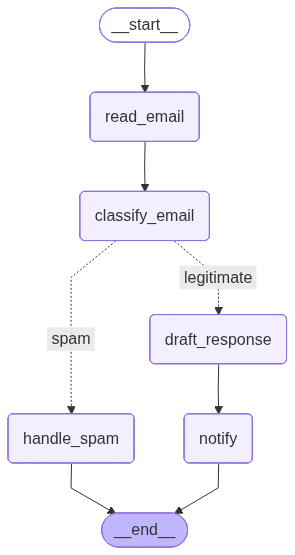

In [7]:
# Create the graph
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)
email_graph.add_node("classify_email", classify_email)
email_graph.add_node("handle_spam", handle_spam)
email_graph.add_node("draft_response", draft_response)
email_graph.add_node("notify", notify)

# Start the edges
email_graph.add_edge(START, "read_email")
# Add edges - defining the flow
email_graph.add_edge("read_email", "classify_email")

# Add conditional branching from classify_email
email_graph.add_conditional_edges(
    "classify_email",
    route_email,
    {
        "spam": "handle_spam",
        "legitimate": "draft_response"
    }
)

# Add the final edges
email_graph.add_edge("handle_spam", END)
email_graph.add_edge("draft_response", "notify")
email_graph.add_edge("notify", END)

# Compile the graph
compiled_graph = email_graph.compile()
compiled_graph

#### Run Graph

In [8]:
# Examples

legitimate_email = {
    "sender": "john.smith@example.com",
    "subject": "Question about your services",
    "body": "Dear Kevin, I was referred to you by a colleague and I'm interested in learning more about your consulting services. Could we schedule a call next week? Best regards, John Smith"
}

spam_email = {
    "sender": "winner@lottery-intl.com",
    "subject": "YOU HAVE WON $5,000,000!!!",
    "body": "CONGRATULATIONS! You have been selected as the winner of our international lottery! To claim your $5,000,000 prize, please send us your bank details and a processing fee of $100."
}

In [11]:
# Process the legitimate email
print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing legitimate email...
KevM Agent is processing an email from john.smith@example.com with subject: Question about your services

Sir, you've received an email from john.smith@example.com.
Subject: Question about your services
Category: inquiry

I've prepared a draft response for your review:
--------------------------------------------------
**Subject:** Re: Question about your services  

**Email Body:**

Dear John,

Thank you for reaching out and for the referral. I’m glad to hear that you’re interested in learning more about our consulting services. I’d be happy to discuss how we can help you achieve your goals.

I’m available for a call next week on [Date/Time Option 1] or [Date/Time Option 2]. If neither of these times works for you, please let me know a few slots that suit your schedule and I’ll do my best to accommodate.

Looking forward to speaking with you.

Best regards,

Kevin [Last Name]  
[Title]  
[Company]  
[Phone] | [Email]  

--- 

*Feel free to adjust the da

In [10]:
# Process the spam email
print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing spam email...
KevM Agent is processing an email from winner@lottery-intl.com with subject: YOU HAVE WON $5,000,000!!!
KevM Agent has marked the email as spam. Reason: None
The email has been moved to the spam folder.


---